class distribution:
Fraudulent:  0.1727485630620034 
non-fraudulent:  99.827251436938


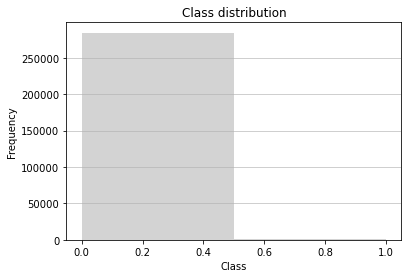

In [1]:
import csv
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.preprocessing import PowerTransformer

np.set_printoptions(suppress=True)

#understanding the data
dataframe = pd.read_csv('creditcard.csv')
dataframe.columns
print('class distribution:\nFraudulent: ', (np.sum(dataframe['Class']/ len(dataframe)*100)), '\nnon-fraudulent: ', 100- (np.sum(dataframe['Class']/ len(dataframe)*100)))

plt.hist(x=dataframe['Class'], bins=2, color='lightgray')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class distribution')
# Scaling Amount and time columns using PowerTransformer
scaled_amount = PowerTransformer(method='yeo-johnson').fit_transform(dataframe['Amount'].values.reshape(-1,1))
scaled_time = PowerTransformer(method='yeo-johnson').fit_transform(dataframe['Time'].values.reshape(-1,1))
dataframe.drop(['Time','Amount'], axis=1, inplace=True)
dataframe.insert(0, 'scaled_time', scaled_amount)
dataframe.insert(1, 'scaled_amount', scaled_amount)


Xoriginal: 
 (284807, 30)
X oversampled: 
 (568630, 30)


Text(0.5, 1.0, 'After oversampling')

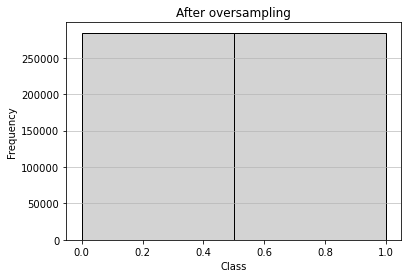

In [2]:
#testing out SMOTE
#note that X and Y oversampled are only for testing and sanity check in this block, SMOTE will need to be performed only during Kfold testing
X = dataframe.drop('Class', axis = 1).values
y = dataframe['Class'].values
kf = KFold(n_splits=5)

sm = SMOTE()
X_oversampled, Y_oversampled = sm.fit_sample(X, y)

print("Xoriginal: \n",X.shape)
print("X oversampled: \n",X_oversampled.shape)

plt.hist(x= Y_oversampled, bins=2, color='lightgray', ec='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('After oversampling')


In [3]:
#importing all the libraries subsequently used

import sklearn.svm as svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

In [10]:
# Oversampling not possible for SVC, takes too long
# Undersampling instead

SKFOLD = StratifiedKFold(n_splits=10, random_state=True, shuffle=True)

fraud = dataframe.loc[dataframe['Class'] == 1]
non_fraud = dataframe.loc[dataframe['Class'] == 0]

chosen_idx = np.random.choice(non_fraud.shape[0], replace=False, size=fraud.shape[0])
non_fraud = dataframe.iloc[chosen_idx]

undersampled_df = pd.concat([fraud, non_fraud]).sample(frac = 1)

X_US = undersampled_df.drop('Class', axis = 1).values
y_US = undersampled_df['Class'].values

accuracy_lst = []
total_confusion = np.zeros((2,2))
correct_confusion = np.zeros((2,2))

for fold, (train_index, test_index) in enumerate(SKFOLD.split(X_US, y_US), 1):
    X_train = X_US[train_index]
    y_train = y_US[train_index]  
    X_test = X_US[test_index]
    y_test = y_US[test_index]  
    model = svm.SVC()
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)
    accuracy_lst.append(model.score(X_test, y_test))
    total_confusion = total_confusion + confusion_matrix(y_test, y_pred)
    correct_confusion = correct_confusion +  confusion_matrix(y_test, y_test)

print("\n\nAverage accuracy: {}".format(np.mean(accuracy_lst)))
print("\nAverage precision: ", total_confusion[1, 1]/np.sum(total_confusion[:, 1]))
print("\nAverage recall: ", total_confusion[1, 1]/np.sum(total_confusion[1, :]))
print("\nSVM confusion matrix")
print (total_confusion)
print("\nCorrect classification")
print (correct_confusion)




Average accuracy: 0.9278086992372707

Average precision:  0.979498861047836

Average recall:  0.8739837398373984

SVM confusion matrix
[[483.   9.]
 [ 62. 430.]]

Correct classification
[[492.   0.]
 [  0. 492.]]


In [1]:

SKFOLD = StratifiedKFold(n_splits=10, random_state=True, shuffle=True)


X = dataframe.drop('Class', axis=1).values
y = dataframe['Class'].values

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

accuracy_lst = []
total_confusion = np.zeros((2,2))
correct_confusion = np.zeros((2,2))

sm = SMOTE()

for fold, (train_index, test_index) in enumerate(SKFOLD.split(X, y), 1):
    X_train = X[train_index]
    y_train = y[train_index]  
    X_test = X[test_index]
    y_test = y[test_index] 
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    model = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'liblinear')
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(X_test)
    accuracy_lst.append(model.score(X_test, y_test))
    total_confusion = total_confusion + confusion_matrix(y_test, y_pred)
    correct_confusion = correct_confusion +  confusion_matrix(y_test, y_test)
    

print("\n\n Average accuracy: {}".format(np.mean(accuracy_lst)))
print (total_confusion)
print (correct_confusion)

NameError: name 'StratifiedKFold' is not defined

In [4]:
# Stochastic Gradient Descent

SKFOLD = StratifiedKFold(n_splits=10, random_state=True, shuffle=True)

accuracy_lst = []
total_confusion = np.zeros((2,2))
correct_confusion = np.zeros((2,2))

for fold, (train_index, test_index) in enumerate(SKFOLD.split(X, y), 1):
    X_train = X[train_index]
    y_train = y[train_index]  
    X_test = X[test_index]
    y_test = y[test_index]  
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    model = SGDClassifier(loss = "hinge", shuffle = True, alpha = 4.5, tol = 0.00001)
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(X_test)
    accuracy_lst.append(model.score(X_test, y_test))
    total_confusion = total_confusion + confusion_matrix(y_test, y_pred)
    correct_confusion = correct_confusion +  confusion_matrix(y_test, y_test)

print("\n\nAverage accuracy
: {}".format(np.mean(accuracy_lst)))
print("\nAverage precision: ", total_confusion[1, 1]/np.sum(total_confusion[:, 1]))
print("\nAverage recall: ", total_confusion[1, 1]/np.sum(total_confusion[1, :]))
print (total_confusion)
print (correct_confusion)



Average accuracy: 0.9991748796457642

Average precision:  0.7323688969258589

Average recall:  0.823170731707317
[[284167.    148.]
 [    87.    405.]]
[[284315.      0.]
 [     0.    492.]]
